In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import imutils.paths as path
from tqdm import tqdm
import os
from skimage.io import imread
import cv2
from tqdm import tqdm
import imutils
from numpy import linalg as LA

In [2]:
positifList=os.listdir('brain_tumor_dataset/yes/')
negatifList=os.listdir('brain_tumor_dataset/no/')
className= os.listdir('brain_tumor_dataset')
print (className)

['no', 'yes']


In [3]:
def crop_brain_contour(image, plot=False):
    #convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.show()
        
    return new_image

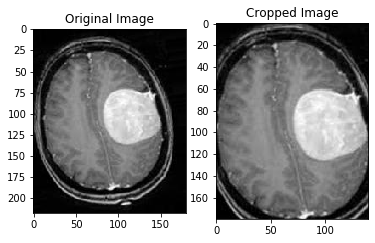

In [4]:
ex_img = cv2.imread('brain_tumor_dataset/yes/aug_Y1_0_1595.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [5]:
def loadCitra (listData, labeling):
    data = []
    label = []
    for i in tqdm (listData):
        if (labeling == 0):
            sample = cv2.imread ('brain_tumor_dataset/yes/'+i)
        elif (labeling == 1):
            sample = cv2.imread ('brain_tumor_dataset/no/'+i)
        sample = crop_brain_contour(sample, plot=False)
        imgGray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
        sampleResize= cv2.resize (imgGray, (64,64) )
        data.append(sampleResize)
        label.append(labeling)
    return (data, label)

In [6]:
citraPositif, IDpositif=loadCitra(positifList, 0)
citraArray = np.array (citraPositif)
print (citraArray.shape)
print("panjang IDpositif:" + str(len(IDpositif))+"\n")

citraNegatif, IDnegatif=loadCitra(negatifList, 1)
citraArray = np.array (citraPositif)
print (citraArray.shape)
print("panjang IDnegatif: " + str(len(IDnegatif))+"\n")

citra = citraPositif+citraNegatif
ex=np.array (citra)
print (ex.shape)
ID=IDpositif+IDnegatif
print("Jumlah Citra: " + str(len(citra)))
print("panjang ID: " + str(len(ID)))

100%|██████████| 1085/1085 [00:05<00:00, 196.62it/s]


(1085, 64, 64)
panjang IDpositif:1085



100%|██████████| 980/980 [00:04<00:00, 237.15it/s]


(1085, 64, 64)
panjang IDnegatif: 980

(2065, 64, 64)
Jumlah Citra: 2065
panjang ID: 2065


In [7]:
# # normalisasi data
citra = np.array(citra)
citra = citra.astype('float32')

In [8]:
def myPCA(dt,nEigen):
    mu=np.mean(dt,axis=0)
    
    nR=dt.shape[0]
    diff=np.array(dt)
    for i in range (nR):
        diff[i,:]=diff[i,:]-mu
        
    A=np.transpose(dt)@dt 

    w, v = LA.eig(A)

    idx=np.argsort(-w)
    Ww=v[:,idx[0:nEigen]]
    
    dP=diff@Ww
    
    return mu, Ww, dP;

In [10]:
#1.Lakukan PCA dekomposisi atas citra input:
#1.1 Convert matrik 400x32x32 menjadi 400x1024
dt=citra.reshape(-1,64*64)/255
print (dt.shape)

#1.2 PCA Dekomposisi
mu, Ww, dP = myPCA(dt,32)

#1.3 Tampilkan ukuran dari PCA
mu.shape, Ww.shape, dP.shape

(2065, 4096)


((4096,), (4096, 32), (2065, 32))

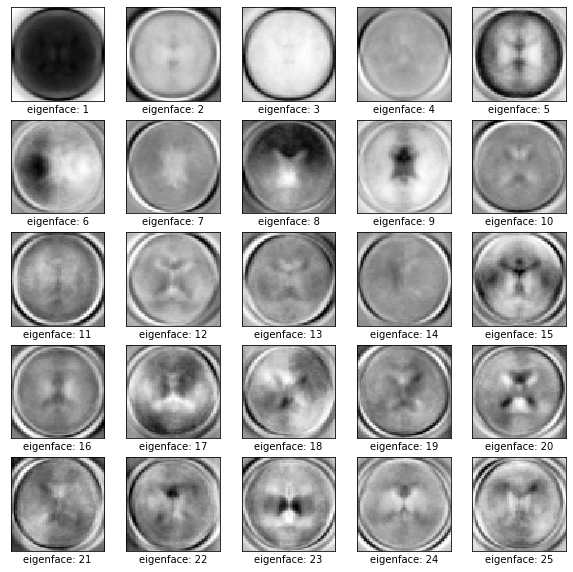

In [24]:
#2. Tampilkan 25 eigen face
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    t=Ww[:,i]
    plt.imshow(t.reshape(64,64), cmap=plt.cm.Greys_r)
    plt.xlabel("eigenface: {}".format(i+1))
plt.show()

In [11]:
#import libarry
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#Function to get performance Classification
def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))    
    print('accuracy is ', accuracy_score(y_test,y_pred))

In [12]:
#3. Split data input menjadi training dan testing dengan ratio 70:30
x_train,x_test,y_train,y_test = train_test_split(dP,ID, stratify=ID, test_size=0.2)

print(len(x_train))
print(len(x_test))

1652
413


In [21]:
#4. Proses pembuatan model yang meliputi initialisasi, training, dan testing
#4.1 K-NEAREST NEIGHBOUR untuk Single k, dalam hal ini dipilih 1

#Define Model dengan Cosine Distance
kNN = KNeighborsClassifier(n_neighbors=1,metric='cosine')

#Training kNN
kNN.fit(x_train,y_train)

print('For Training data: ')
y_pred = kNN.predict(x_train)
print('accuracy is ', accuracy_score(y_train,y_pred))

print('For Testing data: ')
y_pred = kNN.predict(x_test)
generateClassificationReport(y_test,y_pred)

For Training data: 
accuracy is  1.0
For Testing data: 
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       217
           1       0.91      0.98      0.94       196

    accuracy                           0.94       413
   macro avg       0.94      0.94      0.94       413
weighted avg       0.94      0.94      0.94       413

[[197  20]
 [  4 192]]
accuracy is  0.9418886198547215
